In [5]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import uncertainties
from uncertainties import ufloat, unumpy
from uncertainties.umath import log
from scipy.odr import ODR, Model, RealData
from scipy.optimize import fsolve, curve_fit
from matplotlib.ticker import AutoMinorLocator, LogLocator
from scipy import constants

### Data Loader

In [6]:
def load_data(path):
    np.set_printoptions(suppress=True, precision=10)
    data_list = sorted(glob.glob(path))
    data_np = []
    for i in data_list:
        data = pd.read_csv(i, sep=',')
        data_np.append(data.to_numpy())
    return data_np

In [7]:
path_planck = '/Users/danielmiksch/Library/CloudStorage/OneDrive-Persönlich/Uni/C-Praktikum/C45/Planck/*.csv'
data366, data405, data436, data546, data578 = load_data(path=path_planck)

# Measuring the Planck constant

## Custom functions

In [8]:
def exp(p, x):
    A, B, C, U = p
    return A+B*(np.exp(C*(x-U)-1))

def lin(p, x):
    A, M, U = p
    return A+M*(x-U)

def calc_sx(data, range):
    return 0.00025*abs(data)+0.00005*range

def err_x0(beta_exp, beta_lin, cov_lin): #error is calculated using the absoult maximum of the difference of the actual intersection point between exp and lin+/- error of the
    x0s = []
    for i in [beta_lin, beta_lin + cov_lin[1], beta_lin - cov_lin[1]]:
        def diff(x):
            return exp(beta_exp, x) - lin(i, x)
        x0s.append(fsolve(diff, -1.3))
    dx0 = np.max([abs(x0s[0]-x0s[1]), abs(x0s[0]-x0s[2])])
    return dx0



def piecewise(data, threshold, intersection, betaLin, betaExp, mark=False, print_beta=False): #x, y, sx, sy
    modelExp = Model(exp)
    modelLin = Model(lin)
    dataLin = RealData(data[0][:threshold], data[1][:threshold], sx=data[2][:threshold], sy=data[3][:threshold])
    dataExp = RealData(data[0][threshold:], data[1][threshold:], sx=data[2][threshold:], sy=data[3][threshold:])
    odrExp = ODR(dataExp, modelExp, beta0=betaExp)
    odrLin = ODR(dataLin, modelLin, beta0=betaLin)
    outputExp = odrExp.run()
    outputLin = odrLin.run()
    def diff(x):
        return exp(outputExp.beta, x) - lin(outputLin.beta, x)
    x0 = fsolve(diff, intersection)
    sx0 = err_x0(outputExp.beta, outputLin.beta, outputLin.sd_beta)
    if print_beta:
        print('Linear:')
        outputLin.pprint()
        print()
        print('Exponential:')
        outputExp.pprint()
    if mark:
        x_plot = np.linspace(np.min(data[0]), np.max(data[0]), 1000)
        plt.scatter(x0, exp(outputExp.beta, x0), c='lime', zorder=3)
        plt.scatter(data[0][:threshold], data[1][:threshold], c='red', s=8)
        plt.scatter(data[0][threshold:], data[1][threshold:], c='blue', s=8)
        plt.plot(x_plot, exp(outputExp.beta, x_plot), c='blue', linewidth=.8)
        plt.plot(x_plot, lin(outputLin.beta, x_plot), c='red', linewidth=.8)
    
    return outputLin.beta, outputExp.beta, x0, sx0

def plot_planck(data_fit, realData, wavelength, name, save=False, hide=False):
    fig, ax = plt.subplots(dpi=150)

    plt.rcParams["font.family"] = "times"
    plt.rcParams["text.usetex"] = True

    x_lin = np.linspace(min(realData[0]), data_fit[2], 1000)
    x_exp = np.linspace(data_fit[2], max(realData[0])+.1, 1000)

    ax.errorbar(realData[0], realData[1],
                xerr=realData[2], yerr=realData[3],
                capsize=4,
                ecolor='black',
                elinewidth=.6,
                capthick=.6,
                markersize=4, fmt="s",
                markeredgecolor='none', c="black",
                label=f'Photocurrent at $\lambda$={wavelength}nm',
                zorder=2)
    ax.plot(x_lin, lin(data_fit[0], x_lin),
            c='red',
            linewidth=.8,
            label='Piecewise fit',
            zorder=3)
    ax.plot(x_exp, exp(data_fit[1], x_exp),
            c='red',
            linewidth=.8,
            zorder=3)
    for i in [data_fit[2]+data_fit[3], data_fit[2]-data_fit[3]]:
        ax.axvline(i,
                color='grey',
                linestyle='--',
                linewidth=0.8,
                zorder=3)
    ax.axvline(data_fit[2],
                color='grey',
                linestyle='-',
                linewidth=0.8,
                zorder=3)
    ax.set_ylabel('Anode current [nA]', fontsize=12)
    ax.set_xlabel('Counter voltage [V]', fontsize=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(axis='x', which='both',direction='in', labelsize=12, width=1, length=2, bottom=True, top=True)
    ax.tick_params(axis='y', which='both',direction='in', labelsize=12, left=True, right=True)

    plt.annotate(f'{data_fit[2][0]:.3f}', xy=(data_fit[2], ax.get_ylim()[1]), ha='center', va='bottom')

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 0]  

    plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           loc="upper left",
           bbox_to_anchor=(0.02, 0.98),
           fancybox=False,
           edgecolor='black',
           fontsize=10)
    if hide:
        plt.close()
    if save:
        fig.savefig(f'/Users/danielmiksch/Downloads/{name}.pdf')


def plot_boltzmann(x_data, y_data, temp, name, save=False, hide=False):

        def exponential(x, A, B):
                return A*np.exp(B*x)

        popt, pcov = curve_fit(exponential, unumpy.nominal_values(x_data), unumpy.nominal_values(y_data), sigma=unumpy.std_devs(y_data), absolute_sigma=True)
        B = ufloat(popt[1], np.sqrt(pcov[1][1]))
        kB = constants.e/((ufloat(temp, .1)+273.15)*B)

        fig, ax = plt.subplots(dpi=100)

        plt.rcParams["font.family"] = "times"
        plt.rcParams["text.usetex"] = True

        x = np.linspace(min(unumpy.nominal_values(x_data)), max(unumpy.nominal_values(x_data)), 1000)

        ax.errorbar(unumpy.nominal_values(x_data), unumpy.nominal_values(y_data),
                capsize=4,
                xerr=unumpy.std_devs(x_data), yerr=unumpy.std_devs(y_data),
                ecolor='black',
                elinewidth=.6,
                capthick=.6,
                markersize=4, fmt="s",
                markeredgecolor='none', c="black",
                label=f'Collector current at T={name}',
                zorder=2)
        ax.plot(x, exponential(x, popt[0], popt[1]),
                c='red',
                linewidth=.8,
                label='Exponential fit',
                zorder=3)
        ax.set_yscale('log')
        ax.set_ylabel('Collector current [V]', fontsize=12)
        ax.set_xlabel('Base-emitter voltage [V]', fontsize=12)
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=None))
        ax.tick_params(axis='x', which='both',direction='in', labelsize=12, width=1, length=2, bottom=True, top=True)
        ax.tick_params(axis='y', which='both',direction='in', labelsize=12, left=True, right=True)

        handles, labels = plt.gca().get_legend_handles_labels()
        order = [1, 0]  

        plt.legend([handles[idx] for idx in order],
                [labels[idx] for idx in order],
                loc="upper left",
                bbox_to_anchor=(0.02, 0.98),
                fancybox=False,
                edgecolor='black',
                fontsize=10)
        if hide:
                plt.close()
        if save:
                fig.savefig(f'/Users/danielmiksch/Downloads/{name}.pdf')
        return kB, popt

def format_uncert(value):
    val = unumpy.nominal_values(value)
    err = unumpy.std_devs(value)
    if val != 0:
        magnitude = np.floor(np.log10(abs(val)))
    else:
        magnitude = 0
    norm_val = val / (10**magnitude)
    norm_err = err / (10**magnitude)

    formatted = f'{norm_val}e{int(magnitude)} ± {norm_err}e{int(magnitude)}'
    print(formatted)

## Fits

In [9]:
data_fits = []
for i in [data366, data405, data436, data546, data578]:
    x, y, sy, sx = i[:,0], i[:,1], i[:,2], calc_sx(i[:,0], 10)
    data_fits.append([x, y, sx, sy])

In [10]:
fit366 =  piecewise(data_fits[0], 8, -1.3, betaLin=[1,1,1], betaExp=[1,1,1,-1], mark=False, print_beta=False) #data366
fit405 = piecewise(data_fits[1], 10, -1.3, betaLin=[1,1,1], betaExp=[0,.5,1,-1.39], mark=False, print_beta=False) #data405
fit436 = piecewise(data_fits[2], 10, -1.3, betaLin=[1,1,1], betaExp=[0,.5,1,-1.39], mark=False, print_beta=False) #data436
fit546 = piecewise(data_fits[3], 10, -1.3, betaLin=[1,1,1], betaExp=[0,.5,1,-1.39], mark=False, print_beta=False) #data546
fit578 = piecewise(data_fits[4], 13, -.5, betaLin=[1,1,1], betaExp=[0,1,0,0], mark=False, print_beta=False) #data578

breakingVoltage_display = np.array([f'{i[2][0]}+/-{i[3]} V' for i in [fit366, fit405, fit436, fit546, fit578]])

/var/folders/_s/ymfv76ms5rs0hd9l43mh92_80000gn/T/ipykernel_53179/2253035169.py:3: RuntimeWarning: overflow encountered in exp
  return A+B*(np.exp(C*(x-U)-1))
/Users/danielmiksch/miniconda3/envs/juplab/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


## Plots

In [11]:
plot_planck(fit366, data_fits[0], 366, 'fit366', save=False, hide=True,)
plot_planck(fit405, data_fits[1], 405, 'fit405', save=False, hide=True,)
plot_planck(fit436, data_fits[2], 436, 'fit436', save=False, hide=True,)
plot_planck(fit546, data_fits[3], 546, 'fit546', save=False, hide=True,)
plot_planck(fit578, data_fits[4], 578, 'fit578', save=False, hide=True,)

In [12]:
breakingVoltage = np.array([abs(i[2][0]) for i in [fit366, fit405, fit436, fit546, fit578]])
sBV = np.array([i[3] for i in [fit366, fit405, fit436, fit546, fit578]])
freq = constants.c / (np.array([366, 405, 436, 546, 578])*1e-9)
sFreq = constants.c / (np.array([366, 405, 436, 546, 578])*1e-9) * 0.01

### Plot breaking voltages

In [13]:
def linear(p, x):
    A, B = p
    return A+B*x

model_lin = Model(linear)
data_lin = RealData(x=freq, y=breakingVoltage, sx=sFreq, sy=sBV)
odrLin = ODR(data_lin, model_lin, beta0=[-1, 1e-10])
lin_output = odrLin.run()
lin_output.pprint

<bound method Output.pprint of <scipy.odr._odrpack.Output object at 0x13fd8a8c0>>

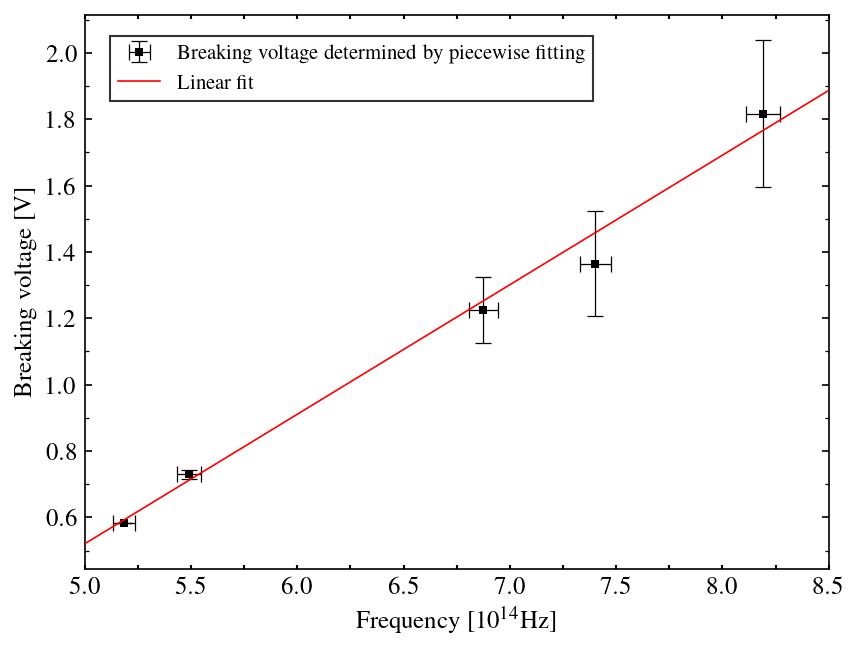

In [14]:
fig, ax = plt.subplots(dpi=150)

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True

x = np.linspace(5, 8.5, 1000)


ax.errorbar(freq / 1e14, breakingVoltage,
            capsize=4,
            xerr=sFreq / 1e14, yerr=sBV,
            ecolor='black',
            elinewidth=.6,
            capthick=.6,
            markersize=4, fmt="s",
            markeredgecolor='none', c="black",
            label=f'Breaking voltage determined by piecewise fitting',
            zorder=2)
ax.set_xlim(5, 8.5)
ax.plot(x, linear([lin_output.beta[0], lin_output.beta[1] * 1e14], x),
        c='red',
        linewidth=.8,
        label='Linear fit',
        zorder=3)
ax.set_ylabel('Breaking voltage [V]', fontsize=12)
ax.set_xlabel(r'Frequency [$10^{14}$Hz]', fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(axis='x', which='both',direction='in', labelsize=12, width=1, length=2, bottom=True, top=True)
ax.tick_params(axis='y', which='both',direction='in', labelsize=12, left=True, right=True)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]  

plt.legend([handles[idx] for idx in order],
        [labels[idx] for idx in order],
        loc="upper left",
        bbox_to_anchor=(0.02, 0.98),
        fancybox=False,
        edgecolor='black',
        fontsize=10)
plt.show()

# fig.savefig('/Users/danielmiksch/Downloads/breaking_voltages.pdf')

## Final result of the Planck constant

In [15]:
planck = ufloat(lin_output.beta[1], np.sqrt(lin_output.cov_beta[1][1])) * constants.e
planck * 1e34 #in 10^-34 Js

6.256753010448323+/-0.6213589014422587

In [16]:
relatice_err = planck.std_dev / planck.nominal_value
f'{relatice_err * 100}%' 

'9.931012146470135%'

# Measuring the Boltzmann constant

### Data

In [17]:
path_boltzmann = '/Users/danielmiksch/Library/CloudStorage/OneDrive-Persönlich/Uni/C-Praktikum/C45/Boltzmann/*.csv'
data120C, data40C, data80C = load_data(path=path_boltzmann)

In [18]:
V40 = unumpy.uarray(data40C[:,0], [0.00025*i+0.00006*1 for i in data40C[:,0]]) # in V
I40 = unumpy.uarray(data40C[:,1], [0.0005*i+0.00015*10 for i in data40C[:,1]]) # in mA 

V80 = unumpy.uarray(data80C[:,0], [0.00025*i+0.00006*1 for i in data80C[:,0]])
I80 = unumpy.uarray(data80C[:,1], [0.0005*i+0.00015*10 for i in data80C[:,1]])

V120 = unumpy.uarray(data120C[:,0], [0.00025*i+0.00006*1 for i in data120C[:,0]])
I120 = unumpy.uarray(data120C[:,1], [0.0005*i+0.00015*10 for i in data120C[:,1]])

### Fit

In [19]:
def exponential(x, A, B):
    return A*np.exp(B*x)

popt, pcov = curve_fit(exponential, unumpy.nominal_values(V40), unumpy.nominal_values(I40), sigma=unumpy.std_devs(I40), absolute_sigma=True)

### Plot

In [20]:
kB40, popt40 = plot_boltzmann(V40, I40, 40, '40°C', save=False, hide=True)
kB80, popt80 = plot_boltzmann(V80, I80, 80, '80°C', save=False, hide=True)
kB120, popt120 = plot_boltzmann(V120, I120, 120, '120°C', save=False, hide=True)
kBs = [kB40, kB80, kB120]
format_uncert(kB120)

1.4752018596169096e-23 ± 0.0006675703450098001e-23


In [21]:
kB_mean = np.mean(kBs)
kB_mean

1.4876962063535354e-23+/-4.13387437075528e-27

In [22]:
format_uncert(kB_mean)

1.4876962063535355e-23 ± 0.00041338743707552804e-23


### Residuals

In [25]:
def calc_residuals(x_data, y_data, model, popt):
    residuals = unumpy.nominal_values(y_data) - model(unumpy.nominal_values(x_data), popt[0], popt[1])
    return residuals

In [28]:
res40 = calc_residuals(V40, I40, exponential, popt40)
res80 = calc_residuals(V80, I80, exponential, popt80)
res120 = calc_residuals(V120, I120, exponential, popt120)

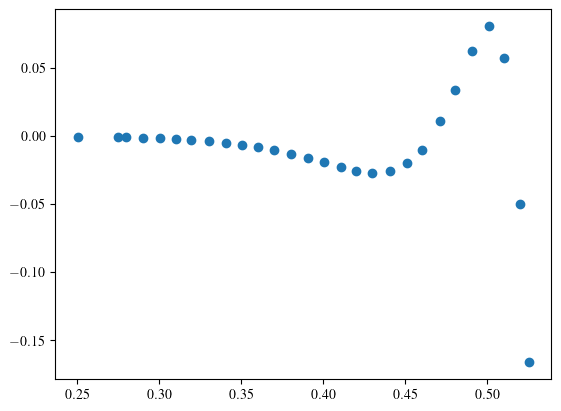

In [27]:
plt.scatter(unumpy.nominal_values(V40), calc_residuals(V40, I40, exponential, popt40))

In [36]:
def plot_residuals(x_data, residuals, temp, name, save=False, hide=False):
    fig, ax = plt.subplots(dpi=150)

    plt.rcParams["font.family"] = "times"
    plt.rcParams["text.usetex"] = True
    ax.errorbar(unumpy.nominal_values(x_data), residuals,
                xerr=None, yerr=None,
                capsize=4,
                ecolor='red',
                elinewidth=.6,
                capthick=.6,
                markersize=6, fmt="s",
                markeredgecolor='none', c="red",
                label=f'Residuals of T={temp}°C',
                zorder=2)
    ax.axhline(0,
                color='grey',
                linestyle='-',
                linewidth=0.8,
                zorder=3)
    ax.set_ylabel('Residuals [mA]', fontsize=12)
    ax.set_xlabel('Base-emitter voltage [V]', fontsize=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(axis='x', which='both',direction='in', labelsize=12, width=1, length=2, bottom=True, top=True)
    ax.tick_params(axis='y', which='both',direction='in', labelsize=12, left=True, right=True)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0]  

    plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           loc="upper left",
           bbox_to_anchor=(0.02, 0.98),
           fancybox=False,
           edgecolor='black',
           fontsize=10)
    if hide:
        plt.close()
    if save:
        fig.savefig(f'/Users/danielmiksch/Downloads/{name}.pdf')

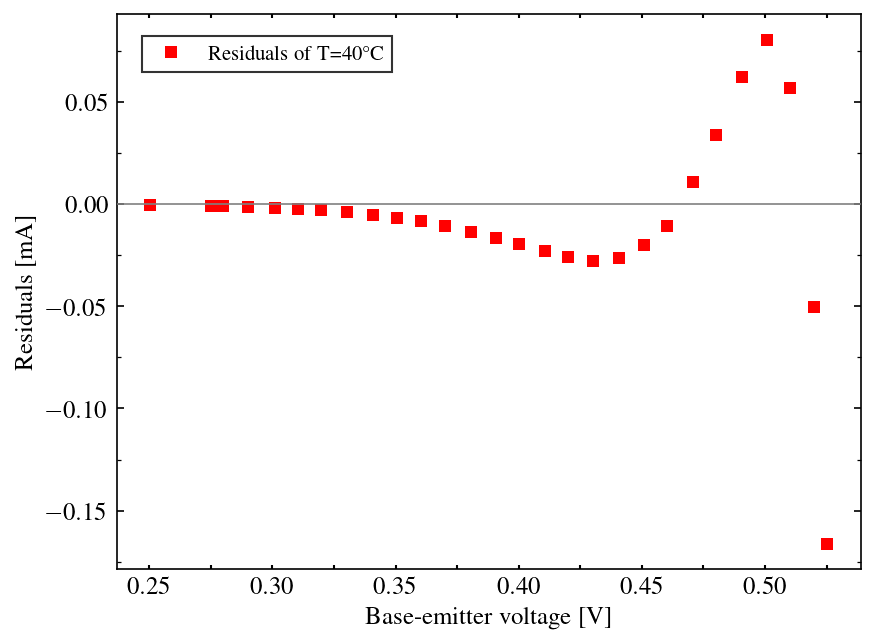

In [37]:
plot_residuals(V40, res40, 40, 'test', save=False, hide=False)